# GFP landscapes around single mutations
Anna Igolkina: igolkinaanna11@gmail.com

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, concat, DataFrame
from scipy.stats.stats import pearsonr, spearmanr
from itertools import combinations
from statsmodels.stats.multitest import fdrcorrection


file_old = '../github/data/final_datasets/avGFP__rf_aminoacid_genotypes_to_brightness.csv'
file_new = '../github/data/final_datasets/amacGFP_cgreGFP_ppluGFP2__final_aminoacid_genotypes_to_brightness.csv'
path_dds = '../data/'

len_gfp = 250

%load_ext rpy2.ipython

In [2]:
%%R
library(ggplot2)
library(reshape2)
colors <- c('ppluGFP'='#70D057', 
            'avGFP'='#D8E34A', 
            'cgreGFP'='#38808E', 
            'amacGFP'='#3A4A87', 
            'amacGFP_V14L'='#42074F')

colors = colors[1:4]
path.figures = '../figures/'


R[write to console]: RStudio Community is a great place to get help:
https://community.rstudio.com/c/tidyverse



## Read data

In [3]:
b_old = read_csv(file_old)[['aa_genotype_pseudo', 'log_brightness', 'aa_genotype_native']]
b_old['gene'] = 'avGFP'
b_new = read_csv(file_new)[['gene', 'aa_genotype_pseudo', 'replicates_mean_brightness', 'aa_genotype_native']]
b_new['replicates_mean_brightness'] = np.log10(b_new['replicates_mean_brightness'])
b_new.columns = ['gene', 'aa_genotype_pseudo', 'log_brightness', 'aa_genotype_native']
meta_info = concat([b_old, b_new], axis=0)
meta_info.index = range(meta_info.shape[0])
genes = meta_info.gene.unique()

br_cutoff = [3, 3.6481159567559627, 4.056237658980227, 3.9626534048932114]

### Correspondence between native and pseudo positions

In [4]:
pos_corresp = np.full((len(genes), len_gfp), 0)
for ig, g in enumerate(genes):
    aa_native = meta_info.aa_genotype_native[meta_info.gene == g]
    aa_pseudo = meta_info.aa_genotype_pseudo[meta_info.gene == g]
#     tmp_corresp
    pos_native = [int(s[1:(len(s)-1)]) for tmp in aa_native.tolist() for s in tmp.split(':')
                 if (s != 'wt') and (':' not in s)]
    pos_pseudo = [int(s[1:(len(s)-1)]) for tmp in aa_pseudo.tolist() for s in tmp.split(':')
                 if (s != 'wt') and (':' not in s)]
    
    print(set(range(max(pos_native))) - set(pos_native))
    for pn, pp in zip(pos_native, pos_pseudo):
        pos_corresp[ig, pn] = pp

# pos_corresp

{0, 1, 118, 119}
{0}
{0}
{0}


### Get ddG 
All observations

In [5]:
# For avGFP: coordinates in ddG are shifted: 'L13P' in dds -> 'L14P' in aa_native
ddg = []
for ig in range(len(genes)):
    file_ddg = f'{path_dds}{genes[ig]}_out.txt'
    ddg_tmp = read_csv(file_ddg, header=None, sep=' ')
    if genes[ig] == 'avGFP':
        pos =  [int(s[1:(len(s)-1)]) + 1 for s in ddg_tmp.iloc[:,0].tolist() 
                if (s != 'wt') and (':' not in s)]
    else:
        pos =  [int(s[1:(len(s)-1)]) for s in ddg_tmp.iloc[:,0].tolist() 
                if (s != 'wt') and (':' not in s)]
    aa_mut =  [s[-1] for s in ddg_tmp.iloc[:,0].tolist() 
            if (s != 'wt') and (':' not in s)]
    aa_wt =  [s[0] for s in ddg_tmp.iloc[:,0].tolist() 
        if (s != 'wt') and (':' not in s)]
    
    pos_new = [f'{w}{p}{m}' for w, p, m in zip(aa_wt, pos_corresp[ig,:][pos], aa_mut)]
    ddg += [list(zip(pos_corresp[ig,:][pos], pos_new, ddg_tmp.iloc[:,1], ddg_tmp.iloc[:,0]))]

ddg[0][0]



(17, 'L17P', 29.731, 'L13P')

## Correspondence between brightness and ddG on single mutations

In [6]:
ig = 3
cmp = [(genes[ig], tmp[1], tmp[2], np.mean(meta_info.log_brightness[meta_info.aa_genotype_pseudo == tmp[1]])) 
       for ig in range(len(genes))
       for tmp in ddg[ig] 
       if (tmp[1] in meta_info.aa_genotype_pseudo[meta_info.gene == genes[ig]].tolist()) and (tmp[2]<60)] 

df_cmp = DataFrame(cmp)
df_cmp.columns = ['gene', 'aa', 'ddg', 'brightness']
df_cmp


,gene,aa,ddg,brightness
0,avGFP,L17P,29.731,2.592364
1,avGFP,N108Y,-6.184,3.821769
2,avGFP,N173H,3.593,3.741145
3,avGFP,L55R,30.014,3.915734
4,avGFP,N138S,2.823,4.006783
...,...,...,...,...
4386,ppluGFP,Y71N,4.443,3.563365
4387,ppluGFP,F190L,8.133,4.113387
4388,ppluGFP,F70C,7.031,3.426370
4389,ppluGFP,G160V,1.422,4.195721


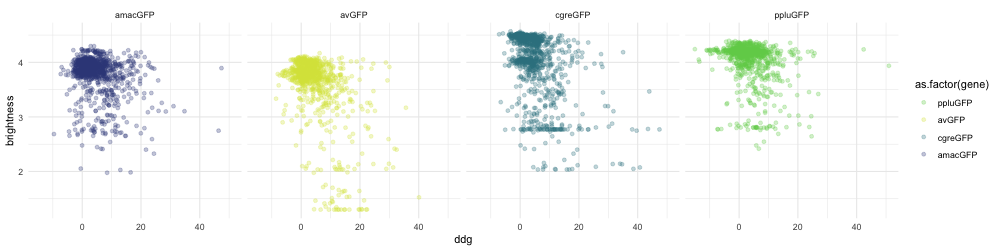

In [7]:
%%R  -i df_cmp -w 1000 -h 250
p <- ggplot(df_cmp, aes(ddg, brightness, color=as.factor(gene) )) + 
  geom_point( alpha = 0.3) + theme_minimal() + scale_color_manual(values=colors) + 
facet_grid(cols = vars(gene))

pdf(paste0(path.figures, 'ddg_brightness_single.pdf'), width=10, height=2.5)
print(p)
dev.off()

p

#### Just cirrelation

In [8]:
cmp_corr = []
for g in genes:
    res = spearmanr(df_cmp.ddg[df_cmp.gene == g], df_cmp.brightness[df_cmp.gene == g])
    cmp_corr += [(g, res.correlation, res.pvalue)]
cmp_corr.sort(key=lambda x:x[1])
cmp_corr
# The highest correlation for cgreGFP -> avGFP -> ppluGFP -> amacGFP

[('cgreGFP', -0.5236127273350303, 5.595257188208809e-81),
 ('avGFP', -0.36548868309329785, 7.671571267644675e-34),
 ('ppluGFP', -0.30963514933999475, 4.3248407062403237e-26),
 ('amacGFP', -0.17248520333227946, 6.560492289905375e-09)]

#### ddG Correlation for bright genotypes only

In [9]:
cmp_corr = []
for ig, g in enumerate(genes):
    res = spearmanr(df_cmp.ddg[(df_cmp.gene == g) & (df_cmp.brightness > br_cutoff[ig])],
                    df_cmp.brightness[(df_cmp.gene == g) & (df_cmp.brightness > br_cutoff[ig])])
    cmp_corr += [(g, res.correlation, res.pvalue)]
cmp_corr.sort(key=lambda x:x[1])
cmp_corr

[('cgreGFP', -0.4928643597754084, 1.2374930208620175e-43),
 ('avGFP', -0.23458885916599245, 4.0604843236425856e-13),
 ('ppluGFP', -0.19568569051239285, 2.435482205604866e-09),
 ('amacGFP', 0.003060556263026809, 0.925777363501032)]

In [10]:
df_cmp

,gene,aa,ddg,brightness
0,avGFP,L17P,29.731,2.592364
1,avGFP,N108Y,-6.184,3.821769
2,avGFP,N173H,3.593,3.741145
3,avGFP,L55R,30.014,3.915734
4,avGFP,N138S,2.823,4.006783
...,...,...,...,...
4386,ppluGFP,Y71N,4.443,3.563365
4387,ppluGFP,F190L,8.133,4.113387
4388,ppluGFP,F70C,7.031,3.426370
4389,ppluGFP,G160V,1.422,4.195721


## Median effect on ddG of singleton mutation along positions

In [11]:
dds_single = np.full((len(genes), len_gfp), np.nan)
for ig, ddg_g in enumerate(ddg):
    for pos in range(len_gfp):
        tmp = [v[2] for v in ddg_g if v[0] == pos]
        if len(tmp) > 0:
            dds_single[ig, pos] = np.median(tmp)
            

dds_single
# Estimate correlation
dds_corr = dict()
for i, j in combinations(range(len(genes)),2):
    x, y = zip(*[(x, y) for x, y in zip(dds_single[i,1:], dds_single[j,1:]) 
                 if not (np.isnan(x) or np.isnan(y))])
    r = spearmanr(x, y)
    dds_corr[f'{genes[i]}_{genes[j]}'] = [r.correlation, r.pvalue]

# br_fdr = fdrcorrection([v[1] for _, v in br_corr.items()], alpha=0.05)
# print(br_fdr[0])
dds_corr


{'avGFP_amacGFP': [0.7008114141130632, 2.2242938722963046e-33],
 'avGFP_cgreGFP': [0.6428867415914113, 8.165090067045898e-27],
 'avGFP_ppluGFP': [0.3246902597996353, 1.8136867915932834e-06],
 'amacGFP_cgreGFP': [0.5884759481707651, 1.0504906842110463e-21],
 'amacGFP_ppluGFP': [0.29008716589525807, 2.3420795885615417e-05],
 'cgreGFP_ppluGFP': [0.454489399491323, 6.031853024410385e-12]}

In [12]:
df_dds_single = DataFrame(dds_single).transpose()
df_dds_single.columns = genes

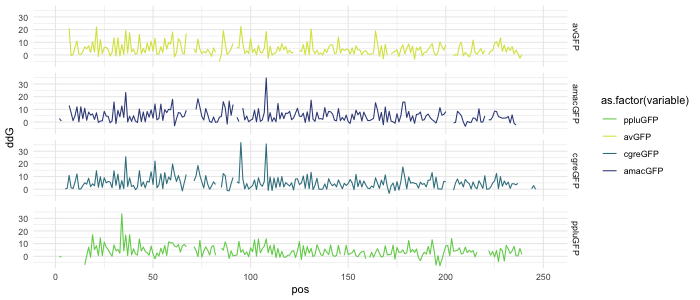

In [13]:
%%R  -i df_dds_single -w 700 -h 300

df_dds_single$pos = 1:nrow(df_dds_single)
df_dds_single
df_dds_single = melt(df_dds_single, id = 'pos')
p <- ggplot(df_dds_single, aes(pos, value, color=as.factor(variable) )) + 
      geom_line() + ylab('ddG') + 
theme_minimal() + scale_color_manual(values=colors) + facet_grid(rows = vars(variable))
#+
# stat_summary(fun.data = "mean_cl_boot", geom = "smooth", se = TRUE)


pdf(paste0(path.figures, 'ddg_median_per_positions.pdf'), width=8, height=3)
print(p)
dev.off()
p

#### Factor Analysis


Call:
factanal(x = df_dds_single[, 1:4], factors = 1, scores = "regression")

Uniquenesses:
  avGFP amacGFP cgreGFP ppluGFP 
  0.335   0.286   0.244   0.800 

Loadings:
        Factor1
avGFP   0.815  
amacGFP 0.845  
cgreGFP 0.869  
ppluGFP 0.448  

               Factor1
SS loadings      2.335
Proportion Var   0.584

Test of the hypothesis that 1 factor is sufficient.
The chi square statistic is 5.99 on 2 degrees of freedom.
The p-value is 0.05 


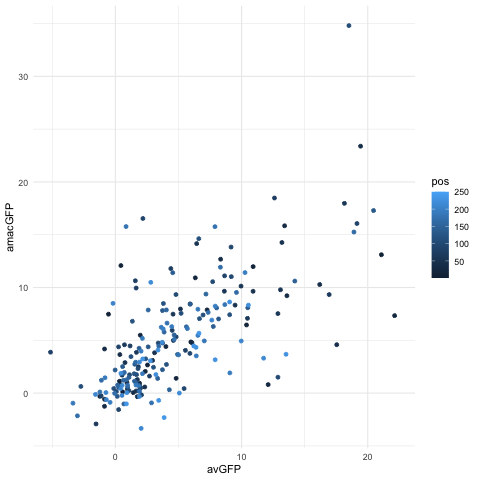

In [14]:
%%R  -i df_dds_single

df_dds_single$pos = 1:nrow(df_dds_single)
p <- ggplot(df_dds_single, aes(avGFP, amacGFP, color=pos)) + 
      geom_point() + theme_minimal()

head(df_dds_single)
df_dds_single <- df_dds_single[rowSums(is.na(df_dds_single)) == 0,]
df_dds_single
fa <- factanal(df_dds_single[,1:4], factors=1, scores='regression')
print(fa)
# plot(fa$scores)
p


### Filtration of stop-codons ('\*') and '.' symbols  
Create matrix of mutations

In [15]:
mx = np.full((meta_info.shape[0], len_gfp),'-')
irow_remove = []
for irow, s in enumerate(meta_info['aa_genotype_pseudo'].tolist()):
    if s == 'wt':
        continue
    s = s.split(':')
    for aa_wt, aa_pos, aa_mut in [(tmp[0], int(tmp[1:-1]), tmp[-1]) for tmp in s]:
        mx[irow, aa_pos] = aa_mut
        if (aa_wt == '*') or (aa_wt == '.') or (aa_mut == '*') or (aa_mut == '.'):
            irow_remove += [irow]
irow_remove = list(set(irow_remove))
irow_remove.sort()

# Filtration
print(f'Removed: {len(irow_remove)} elemnts with stop-codons and etc.')
mx = np.delete(mx, irow_remove, axis=0)
meta_info = meta_info.drop(irow_remove)
meta_info.index = range(meta_info.shape[0])
len_gfp = np.max(np.where(np.sum(mx != '-', axis = 0) != 0)) + 1
mx = mx[:,:len_gfp]
print(f'Remained: matrix of ({mx.shape[0]} x {mx.shape[1] - 1})')
# first column of matrix havs the zero index - do not used


Removed: 6806 elemnts with stop-codons and etc.
Remained: matrix of (141144 x 245)


### Find singletons for each gene

In [16]:
# Get unique genes and their 
genes_idx = [list(np.where(meta_info.gene == g)[0])
            for g in genes]
print(f'Number of proteins: {[(g, len(idx)) for g, idx in zip(genes, genes_idx)]}')

genes_sngl = [[i for i, v in zip(idx, np.sum(mx[idx,:] != '-',axis=1)) if v == 1]
              for idx in genes_idx]
print(f'Number of signletons: {[(g, len(idx)) for g, idx in zip(genes, genes_sngl)]}')


Number of proteins: [('avGFP', 51715), ('amacGFP', 33511), ('cgreGFP', 24516), ('ppluGFP', 31402)]
Number of signletons: [('avGFP', 1084), ('amacGFP', 1201), ('cgreGFP', 1169), ('ppluGFP', 1141)]


### Brightness cutoffs

In [17]:
p_cutoff = 0.7
br_cutoff = []
for i in range(len(genes)):
    mx_gene = mx[genes_idx[i],:]
    br_gene = meta_info.log_brightness[genes_idx[i]]
    br_min = min(br_gene)
    br_wt = br_gene[np.sum(mx_gene != '-',axis = 1) == 0]
    br_cutoff += list(br_min + p_cutoff * (br_wt - br_min))
print(br_cutoff)



n_cutoff = 4
br_rmp = {'amacGFP': [  897.5,  1571. ,  2865.5,  4447.5,  7381.5, 10533. , 15205. ],
 'cgreGFP': [ 1179. ,  2594. ,  5606. , 11382.5, 18682.5, 26388.5, 37143.5],
 'ppluGFP': [ 1179. ,  2388.5,  4721.5,  9176. , 13279. , 18263.5, 24702.5]}

for i, g in enumerate(genes):
    if g in br_rmp.keys():
        br_cutoff[i] = np.log10(br_rmp[g][n_cutoff - 1])
    else:
        br_cutoff[i] = 3
        
br_cutoff


[2.9884742640999997, 3.5751872504898823, 3.9790954163864756, 3.789332226179616]


[3, 3.6481159567559627, 4.056237658980227, 3.9626534048932114]

## Median effect of singleton mutation along positions

In [18]:
apply_br_cutoff = True
# apply_br_cutoff = False

br_single = np.full((len(genes), len_gfp), np.nan)
for i, idx in enumerate(genes_sngl):
    mx_single = mx[idx,:]
    b_single = meta_info.log_brightness[idx]
    # apply brightness cutoff
    if apply_br_cutoff:
        mx_single = mx_single[b_single > br_cutoff[i],:]
        b_single = b_single[b_single > br_cutoff[i]]
    for pos in range(len_gfp):
        b_tmp = b_single[mx_single[:,pos] != '-']
        if len(b_tmp) > 0:
            br_single[i, pos] = np.median(b_tmp)


# Estimate correlation
br_corr = dict()
for i, j in combinations(range(len(genes)),2):
    x, y = zip(*[(x, y) for x, y in zip(br_single[i,1:], br_single[j,1:]) 
                 if not (np.isnan(x) or np.isnan(y))])
    r = spearmanr(x, y)
    br_corr[f'{genes[i]}_{genes[j]}'] = [r.correlation, r.pvalue]

br_fdr = fdrcorrection([v[1] for _, v in br_corr.items()], alpha=0.05)
print(br_fdr[0])
br_corr



[ True  True  True  True  True  True]


{'avGFP_amacGFP': [0.4182116212547741, 2.6813731409950316e-10],
 'avGFP_cgreGFP': [0.34584697246172913, 3.79215144940371e-07],
 'avGFP_ppluGFP': [0.28412405049397116, 4.979521377349516e-05],
 'amacGFP_cgreGFP': [0.37661872355321274, 2.4133989074673024e-08],
 'amacGFP_ppluGFP': [0.21062073442822332, 0.0032005601164085138],
 'cgreGFP_ppluGFP': [0.2508463089578548, 0.00043373480699179876]}

In [19]:
df_br_single = DataFrame(br_single).transpose()
df_br_single.columns = genes
df_br_single

,avGFP,amacGFP,cgreGFP,ppluGFP
0,NaN,NaN,NaN,NaN
1,NaN,3.975922,4.487416,4.211443
2,3.651014,3.967115,4.496184,4.213768
3,NaN,NaN,4.490048,NaN
4,NaN,NaN,4.489692,NaN
...,...,...,...,...
241,3.688841,3.953149,NaN,4.253940
242,3.644676,3.966870,NaN,NaN
243,3.703283,3.995091,4.449394,NaN
244,3.747428,3.978488,4.503045,NaN


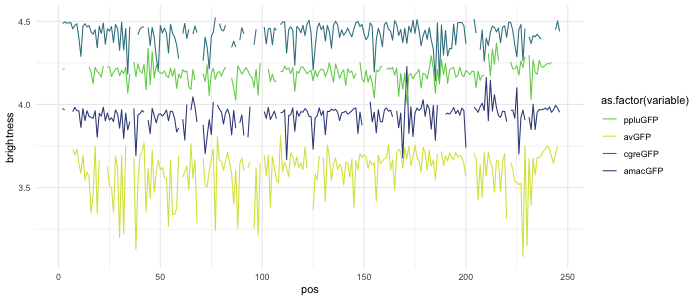

In [20]:
%%R  -i df_br_single -w 700 -h 300

df_br_single$pos = 1:nrow(df_br_single)
df_br_single
df_br_single = melt(df_br_single, id = 'pos')
p <- ggplot(df_br_single, aes(pos, value, color=as.factor(variable) )) + 
      geom_line() + ylab('brightness') +
theme_minimal() + scale_color_manual(values=colors) #+
# stat_summary(fun.data = "mean_cl_boot", geom = "smooth", se = TRUE)

pdf(paste0(path.figures, 'brightness_median_per_positions.pdf'), width=8, height=3)
print(p)
dev.off()
p



Call:
factanal(x = df_br_single[, 1:4], factors = 1, scores = "regression")

Uniquenesses:
  avGFP amacGFP cgreGFP ppluGFP 
  0.729   0.775   0.515   0.797 

Loadings:
        Factor1
avGFP   0.520  
amacGFP 0.474  
cgreGFP 0.696  
ppluGFP 0.451  

               Factor1
SS loadings      1.184
Proportion Var   0.296

Test of the hypothesis that 1 factor is sufficient.
The chi square statistic is 2.58 on 2 degrees of freedom.
The p-value is 0.275 


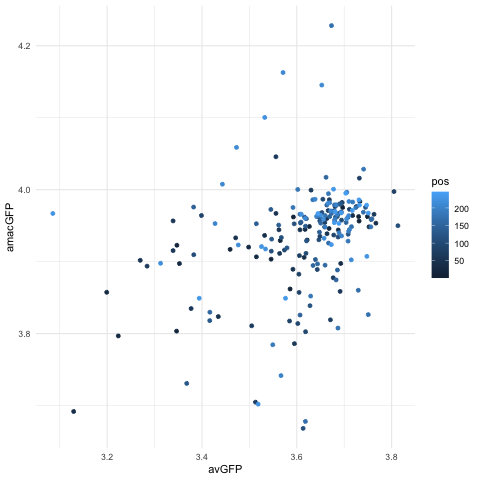

In [21]:
%%R -i df_br_single

df_br_single$pos = 1:nrow(df_br_single)
p <- ggplot(df_br_single, aes(avGFP, amacGFP, color=pos)) + 
      geom_point() + theme_minimal()

head(df_br_single)
df_br_single <- df_br_single[rowSums(is.na(df_br_single)) == 0,]
df_br_single
fa <- factanal(df_br_single[,1:4], factors=1, scores='regression')
print(fa)
# plot(fa$scores)
p

## Correspondence between brightness and ddG on positions

In [22]:
cmp = [];
for ig in range(len(genes)):
    x, y = zip(*[(x, y) for x, y in zip(br_single[ig,1:], dds_single[ig,1:]) 
             if not (np.isnan(x) or np.isnan(y))])
    res = spearmanr(x, y)
    cmp += [(genes[ig], res.correlation, res.pvalue)]
cmp.sort(key=lambda x: x[1])
cmp

[('cgreGFP', -0.5580806604328973, 6.428029928104624e-19),
 ('avGFP', -0.47619869573568235, 1.869181437735044e-13),
 ('amacGFP', -0.3858397154573457, 1.0193621389346615e-08),
 ('ppluGFP', -0.3817456380385442, 1.275074186454026e-08)]

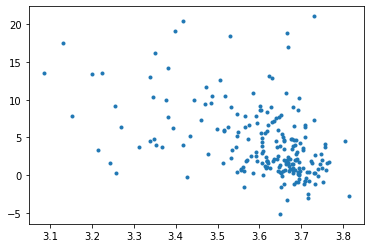

In [23]:
ig = 0
plt.plot(br_single[ig,1:len_gfp], dds_single[ig,1:len_gfp], '.')

# Estimate landscape
### ...for the initial sequencies

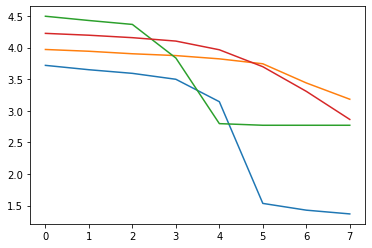

In [24]:
def get_landscape(mx_gene, br_gene, n_steps=8, shift=0):
    """
    Get landscape for a matrix
    """
    n_mut = np.sum(mx_gene != '-',axis=1)
    n_mut_unique = np.unique(n_mut)
#     print(n_mut_unique)
    land = np.full(n_steps, 0.0)
    for step in range(n_steps):
        if (step + shift) in n_mut_unique:
            if (sum(n_mut == (step + shift)) < 5) and step != 0: 
                continue
            land[step] = np.median(br_gene[n_mut == (step + shift)]) 
    return land


land_ref = []
for i in range(len(genes)):
    idx = genes_idx[i]
    mx_gene = mx[idx,:]
    br_gene = meta_info.log_brightness[idx]
    land_ref += [get_landscape(mx_gene, br_gene)]
plt.plot(np.transpose(land_ref))


In [25]:
land_ref

[array([3.71921213, 3.65017114, 3.59273829, 3.49894722, 3.14388736,
        1.53362787, 1.42663762, 1.36722946]),
 array([3.97073335, 3.94256292, 3.90288931, 3.87401354, 3.82239531,
        3.74424424, 3.44087959, 3.18289462]),
 array([4.49691402, 4.42958852, 4.36744344, 3.8356166 , 2.79666908,
        2.77085201, 2.77085201, 2.77085201]),
 array([4.22582375, 4.19648707, 4.15770068, 4.10364363, 3.96601024,
        3.69777458, 3.30789793, 2.86314482])]

# Brightness landscape per pos

In [26]:
n_steps = 3
br_profiles = []
landscapes = []
for ig in range(len(genes)):  # index of gene
    print(ig)
    profile = []
    mx_ig = mx[genes_idx[ig],:]
    br_ig = meta_info.log_brightness[genes_idx[ig]]
    
    for isngl in genes_sngl[ig]:  # index of single
#         print(isngl)
        # Consider only peaks with high brightness after the first mutation
        if meta_info.log_brightness[isngl] <= br_cutoff[ig]:
            continue

        pos_sngl = list(np.where(mx[isngl] != '-')[0])
        
        idx = [i[0].item() for i in mx_ig[:,pos_sngl] == mx[isngl,pos_sngl].item()]
        
        if sum(idx) <= 100:
            continue
        
        mx_tmp = mx_ig[idx,:]
        br_tmp = br_ig[idx]
        land_tmp = get_landscape(mx_tmp, br_tmp, shift=1)
        land_tmp = land_tmp / land_tmp[0] * land_ref[ig][0]

        landscapes += [(genes[ig], pos_sngl[0], isngl, land_tmp)]
            
        score = np.mean(land_tmp[1:(n_steps+1)] - land_ref[ig][1:(n_steps+1)])
        profile += [(pos_sngl[0], score)]
    
    br_profiles += [profile]
        


0
1
2
3


### Profile of brighntess in blocks

In [27]:
block_boundaries = [0, 14, 23, 29, 38, 42, 51, 57, 76, 84, 91, 95, 106, 118, 121, 129, 150, 175, 190, 204, 214, 223, 233, 250]

block_profiles = np.full((len(genes), len(block_boundaries)-1), np.nan)
for ig in range(len(genes)):
    for ibnd in range(len(block_boundaries)-1):
        br_tmp = [b for p, b in br_profiles[ig] 
                  if (p >= block_boundaries[ibnd]) and (p < block_boundaries[ibnd+1])]
        block_profiles[ig, ibnd] = np.mean(br_tmp)

block_profiles = DataFrame(block_profiles).transpose()
block_profiles.columns = genes
block_profiles

block_profiles.corr()

,avGFP,amacGFP,cgreGFP,ppluGFP
avGFP,1.000000,0.245564,0.500617,0.487916
amacGFP,0.245564,1.000000,0.205591,0.646984
cgreGFP,0.500617,0.205591,1.000000,0.380434
ppluGFP,0.487916,0.646984,0.380434,1.000000


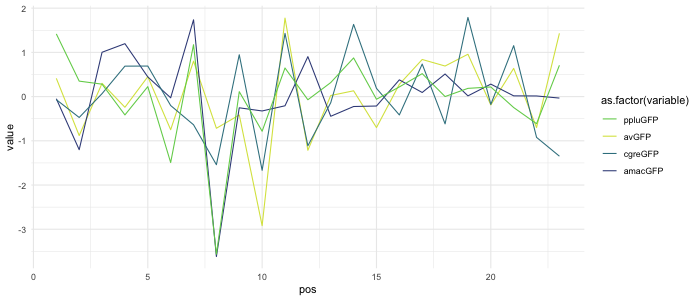

In [28]:
%%R -i block_profiles -w 700 -h 300

# Standardization
block_profiles = as.data.frame(apply(block_profiles, 2, function(x) (x-mean(x))/sd(x)))            
                       
block_profiles$pos = 1:nrow(block_profiles)
block_profiles
block_profiles = melt(block_profiles, id = 'pos')
ggplot(block_profiles, aes(pos, value, color=as.factor(variable) )) + 
      geom_line() + 
theme_minimal() + scale_color_manual(values=colors)


## Distribution of sharpness

In [29]:


sharp_cutoff = []
for ig in range(len(genes)):
    br_tmp = meta_info.log_brightness[meta_info.gene == genes[ig]]
    sharp_cutoff += [min(br_tmp) + (max(br_tmp) - min(br_tmp))/2]
print(sharp_cutoff)


using_cutoff = br_cutoff
# using_cutoff = sharp_cutoff

sharpness = []
for ig, g in enumerate(genes):
    land_g = [l for g_tmp, pos, idx, l in landscapes if (g_tmp == g)]
    
    sharpness += [(g, v) for v in [min(np.where(land_i < br_cutoff[ig])[0]) 
                   if len(np.where(land_i < using_cutoff[ig])[0]) > 0 else -1
                   for land_i in land_g] 
                 if v > 0]
    
    
# Estimation of sharpness for the initial sequencies
sharpness_ref = []
for cutoff, land in zip(using_cutoff, land_ref):
    sharpness_ref += [min(np.where(land < cutoff)[0])]
    
sharpness_ref

[2.703264151, 3.4619134635499007, 3.686927322156458, 3.6079555465852735]


[5, 6, 3, 5]

In [30]:
sharpness = DataFrame(sharpness)
sharpness.columns = ['gene', 'sharpness']
sharpness

sharpness_ref = DataFrame(sharpness_ref)
sharpness_ref.index = genes
sharpness_ref.columns = ['sharpness']
sharpness_ref

,sharpness
avGFP,5
amacGFP,6
cgreGFP,3
ppluGFP,5


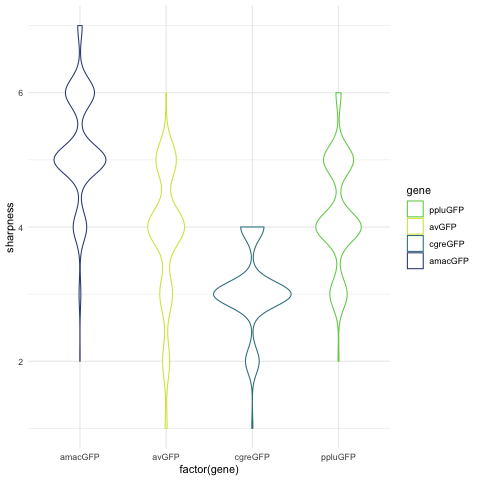

In [31]:
%%R -i sharpness

# cute and uninformalive plot
ggplot(sharpness, aes(factor(gene), sharpness, color = gene)) +
geom_violin() + scale_color_manual(values=colors) + theme_minimal()


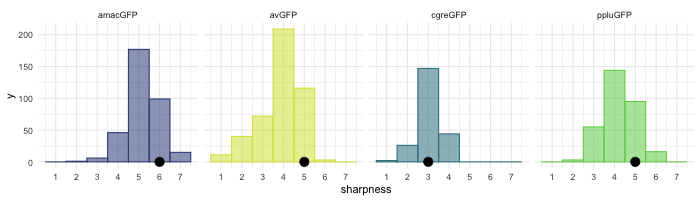

In [32]:
%%R -i sharpness -i sharpness_ref  -w 700 -h 200

sharpness_ref
sharpness_ref$gene = rownames(sharpness_ref)
sharpness_ref

p <- ggplot(sharpness, aes(sharpness, color = gene)) +
geom_histogram(binwidth=1, aes(fill=gene, alpha=0.5)) + 
scale_color_manual(values=colors) + theme_minimal() +  scale_fill_manual(values=colors) +
scale_x_continuous(breaks=seq(1,9,1)) +
geom_point(data=sharpness_ref, aes(x=sharpness, y=0), color = 'black', size=4) +
theme(legend.position = "none") +
facet_grid(cols = vars(gene))


pdf(paste0(path.figures, 'sharpness_hist.pdf'), width=8, height=3)
print(p)
dev.off()
p



## Sharpness and ddG/brightness

In [33]:
sharpness = []
for ig, g in enumerate(genes):
    land_g, land_idx = zip(*[(l, idx) for g_tmp, pos, idx, l in landscapes if g_tmp == g ])
    sharpness_tmp = [(g, v) for v in [min(np.where(land_i < br_cutoff[ig])[0]) 
                   if len(np.where(land_i < br_cutoff[ig])[0]) > 0 else len(land_i)
                   for land_i in land_g] ]

    # Get ddG
    ddg_substitutions, ddg_values = zip(*[(v[1], v[2]) for v in ddg[ig]])
    ddg_substitutions = [v[1] for v in ddg[ig]]
    aa_substitutions = meta_info.aa_genotype_pseudo[list(land_idx)].tolist()
    sharpness_tmp, aa_substitutions = zip(*[(v, aa) for aa, v in zip(aa_substitutions, sharpness_tmp) 
                                           if aa in ddg_substitutions])
    ddg_val = [ddg_values[min(np.where([s == aa for s in ddg_substitutions])[0])] 
               for aa in aa_substitutions]
    br_val = [np.mean(meta_info.log_brightness[meta_info.aa_genotype_pseudo == aa])
               for aa in aa_substitutions]
    sharpness_tmp = [(v[0], v[1], d, b) for d, b, v in zip(ddg_val, br_val, sharpness_tmp)]
    sharpness += sharpness_tmp

In [34]:
sharpness = DataFrame(sharpness)
sharpness.columns = ['gene', 'sharpness', 'ddG', 'brightness']


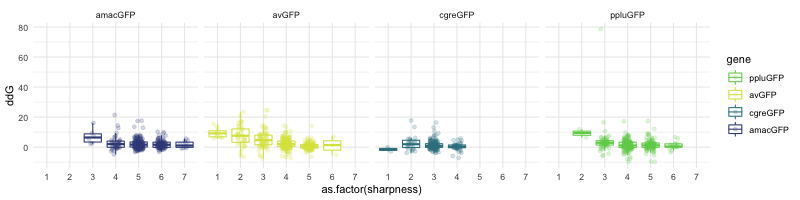

In [35]:
%%R -i sharpness -w 800 -h 200

p <- ggplot(sharpness, aes(as.factor(sharpness), ddG, color = gene)) +
# p <- ggplot(sharpness, aes(as.factor(sharpness), brightness, color = gene)) +
geom_boxplot(outlier.shape = NA) + scale_color_manual(values=colors) + theme_minimal() + 
facet_grid(cols = vars(gene)) + geom_jitter( alpha = 0.2, width = 0.2) 

pdf(paste0(path.figures, 'ddg_vs_sharpness.pdf'), width=8, height=3)
print(p)
dev.off()
p


### Correlation between sharpness and stability

In [36]:
flag = 'ddG'
# flag = 'brightness'

sharpness_corr = []
for g in genes:
    if flag == 'ddG':
        res = spearmanr(sharpness.sharpness[sharpness.gene == g], 
                        sharpness.ddG[sharpness.gene == g])
    else:
        res = spearmanr(sharpness.sharpness[sharpness.gene == g], 
                    sharpness.brightness[sharpness.gene == g])

    sharpness_corr += [(g, res.correlation, res.pvalue)]
sharpness_corr.sort(key=lambda x: x[1])
sharpness_corr

[('avGFP', -0.47988655907318784, 4.2926078725357994e-26),
 ('ppluGFP', -0.18991763961006902, 0.0007921956663730209),
 ('cgreGFP', -0.14204353932912434, 0.03786740233683335),
 ('amacGFP', -0.058770858385214925, 0.29996953178802443)]

## Landscape plot

In [37]:
landscapes_df = None
for g in genes:
    landscapes_gene = [v[3] for v in landscapes if (v[0] == g) ]
    for j in range(len(landscapes_gene)):
        v = landscapes_gene[j]
        flag = False
        for i in range(len(v)):
            if v[i] < br_cutoff[ig]:
                flag = True
            elif flag == True:
                v[i] = 0
        
        landscapes_gene[i] = v
    landscapes_gene
    
    landscapes_gene = DataFrame(landscapes_gene)
    landscapes_gene.columns = [f'{i+1}' for i in range(landscapes_gene.shape[1])]
    landscapes_gene['gene'] = g
    landscapes_gene
    if landscapes_df is None:
        landscapes_df = landscapes_gene
    else:
        landscapes_df = concat((landscapes_df, landscapes_gene))
landscapes_df

landscapes_ref_df = DataFrame(land_ref)
landscapes_ref_df.columns = [f'{i+1}' for i in range(landscapes_ref_df.shape[1])]
landscapes_ref_df['gene'] = genes
landscapes_ref_df


br_cutoff_df = DataFrame(br_cutoff)
br_cutoff_df.index = genes
br_cutoff_df.columns = ['cutoff']


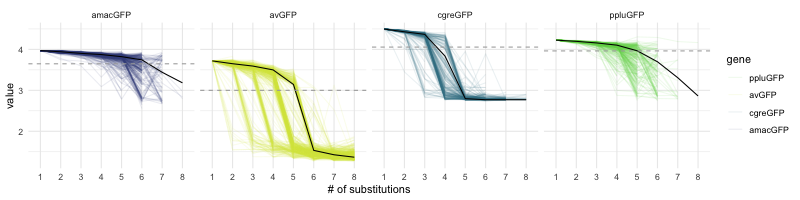

In [38]:
%%R -i landscapes_df -i landscapes_ref_df -i br_cutoff_df -w 800 -h 200

landscapes_df$id <- 1:nrow(landscapes_df)
landscapes_df[landscapes_df == 0] = NaN
df.landscape <- melt(landscapes_df, id = c('id', 'gene'))

df.landscape.ref <- melt(landscapes_ref_df, id = c('gene'))
br_cutoff_df$gene = rownames(br_cutoff_df)

head(br_cutoff_df)

p <- ggplot(df.landscape, aes(as.factor(variable), value, color = gene, group=id)) +
geom_line(alpha=0.1) + scale_color_manual(values=colors) + 
geom_line(data = df.landscape.ref, aes(as.factor(variable), value, group=gene), color='black') +
geom_hline(data=br_cutoff_df, aes(yintercept=cutoff), linetype="dashed", color = "darkgrey") + 
theme_minimal() + xlab('# of substitutions') + 
facet_grid(cols = vars(gene))



pdf(paste0(path.figures, 'sharpness_landscape.pdf'), width=8, height=3)
print(p)
dev.off()
p